# Basic Chatbot

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from IPython.display import Image, display

load_dotenv()

True

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph = StateGraph(State)

In [5]:
# from langchain.chat_models import init_chat_model
# llm = init_chat_model('groq:llama3-8b-8192')


llm = ChatGroq(model="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027651F2CD70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027651F2D940>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [33]:
def chat(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

In [34]:
graph.add_node(chat)

graph.add_edge(START, 'chat')
graph.add_edge('chat', END)

In [36]:
gr = graph.compile()

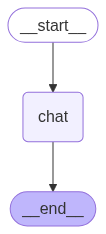

In [ ]:
display(Image(gr.get_graph().draw_mermaid_png()))

In [41]:
res = gr.invoke({'messages': 'hi'})
res

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='d0138cf4-3604-4621-abf2-712bdbdfdb65'),
  AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.018842165, 'prompt_time': 0.001888378, 'queue_time': 0.169588147, 'total_time': 0.020730543}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--b829a469-6e39-45cc-9835-500c89a69657-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}

In [43]:
res['messages'][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

# Add Tools

In [ ]:
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

In [7]:
tavily = TavilySearch(max_results=2)

tools = [tavily]

In [6]:
tavily.invoke('What is the capital of France?')

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
   'title': 'Paris facts: the capital of France in history',
   'content': 'Paris, France Paris facts: Paris, the capital of France Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris is a world capital city of shopping and fashion, with Channel, Dior, Vuitton, Yves Saint Laurent among many other top french fashion brands. Paris facts: the capital of France in history Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. Paris remained the capital of France until today, with one four year interruption.',
   'score': 

In [8]:
def mul(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: The product of a and b
    """
    return a * b


tools.append(mul)
tools

[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 <function __main__.mul(a: int, b: int) -> int>]

In [9]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools.invoke('What is the capital of France?')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's2q7yg4tw', 'function': {'arguments': '{"query":"What is the capital of France?","search_depth":"basic","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 2279, 'total_tokens': 2367, 'completion_time': 0.063826655, 'prompt_time': 0.250151167, 'queue_time': 0.17059520899999997, 'total_time': 0.313977822}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c9ef421-2637-4374-b1a9-f40adf1311a8-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'What is the capital of France?', 'search_depth': 'basic', 'topic': 'general'}, 'id': 's2q7yg4tw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2279, 'output_tokens': 88, 'total_tokens': 2367})

In [9]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001265B78FCB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001265B934980>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [10]:
def chat(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

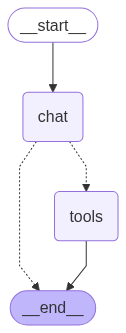

In [11]:
graph = StateGraph(State)

graph.add_node(chat)
graph.add_node(ToolNode(tools))

graph.add_edge(START, 'chat')
graph.add_conditional_edges('chat', tools_condition)

gr = graph.compile()

display(Image(gr.get_graph().draw_mermaid_png()))

In [12]:
res = gr.invoke({'messages': 'multiply 5 by 44'})
res

{'messages': [HumanMessage(content='multiply 5 by 44', additional_kwargs={}, response_metadata={}, id='e3d6e5fd-056c-4d2a-9ac4-2f9569795938'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '579djq4sg', 'function': {'arguments': '{"a":5,"b":44}', 'name': 'mul'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 2278, 'total_tokens': 2350, 'completion_time': 0.093307669, 'prompt_time': 0.254465809, 'queue_time': 0.16642298900000002, 'total_time': 0.347773478}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--85f6ebec-fc2c-480c-8b38-4d139ee5b513-0', tool_calls=[{'name': 'mul', 'args': {'a': 5, 'b': 44}, 'id': '579djq4sg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2278, 'output_tokens': 72, 'total_tokens': 2350}),
  ToolMessage(content='220', name='mul', id='1400447b-b75a-4705-95fa-f59186838d03', tool_call_id='579djq4sg')]}

In [13]:
for message in res['messages']:
    message.pretty_print()

================================ Human Message =================================

multiply 5 by 44
================================== Ai Message ==================================
Tool Calls:
  mul (579djq4sg)
 Call ID: 579djq4sg
  Args:
    a: 5
    b: 44
================================= Tool Message =================================
Name: mul

220


# ReAct

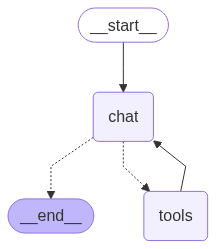

In [ ]:
graph = StateGraph(State)

graph.add_node(chat)
graph.add_node(ToolNode(tools))

graph.add_edge(START, 'chat')
graph.add_conditional_edges('chat', tools_condition)
graph.add_edge('tools', 'chat')

gr = graph.compile()

display(Image(gr.get_graph().draw_mermaid_png()))

In [18]:
res = gr.invoke({'messages': 'multibly 5 by 5, and tell me What is the capital of France?'})
res

{'messages': [HumanMessage(content='multibly 5 by 5, and tell me What is the capital of France?', additional_kwargs={}, response_metadata={}, id='a7a4e410-b16e-4e9c-9d8e-74c4cb5b5eec'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xkmdw8vzm', 'function': {'arguments': '{"a":5,"b":5}', 'name': 'mul'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 2290, 'total_tokens': 2383, 'completion_time': 0.068530666, 'prompt_time': 0.251972827, 'queue_time': 0.170796022, 'total_time': 0.320503493}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--91977a3c-3877-4125-be0d-c6c12ef268be-0', tool_calls=[{'name': 'mul', 'args': {'a': 5, 'b': 5}, 'id': 'xkmdw8vzm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2290, 'output_tokens': 93, 'total_tokens': 2383}),
  ToolMessage(content='25', name='mul', id='37a03e78-7c1c-4bf9-b322-e7bd6038bb7d', t

In [19]:
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

multibly 5 by 5, and tell me What is the capital of France?
================================== Ai Message ==================================
Tool Calls:
  mul (xkmdw8vzm)
 Call ID: xkmdw8vzm
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: mul

25
================================== Ai Message ==================================
Tool Calls:
  tavily_search (n3hg81g07)
 Call ID: n3hg81g07
  Args:
    query: What is the capital of France?
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "What is the capital of France?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://home.adelphi.edu/~ca19535/page%204.html", "title": "Paris facts: the capital of France in history", "content": "page 4\n\n===============\n\nHomeSpainSydn

# Add Memory

In [23]:
from langgraph.checkpoint.memory import MemorySaver

mem = MemorySaver()

In [20]:
res = gr.invoke({'messages': "Hi, i'm ayad"})
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

Hi, i'm ayad
================================== Ai Message ==================================

Hi Ayad! It's nice to meet you. How can I assist you today?


In [21]:
res = gr.invoke({'messages': "Hi, what is my name?"})
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

Hi, what is my name?
================================== Ai Message ==================================

Unfortunately, I don't have any information about your name.


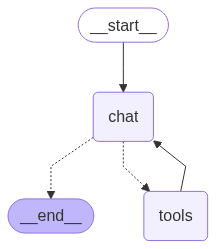

In [29]:
gr = graph.compile(checkpointer=mem)

display(Image(gr.get_graph().draw_mermaid_png()))

In [31]:
config = {'configurable' : {'thread_id' : 'ayad-010'}}

res = gr.invoke({'messages': "Hi, i'm ayad"}, config=config)
res

{'messages': [HumanMessage(content="Hi, i'm ayad", additional_kwargs={}, response_metadata={}, id='9a37ee58-e55e-4fe2-a5be-82b3ff9c7ed8'),
  AIMessage(content="Hello Ayad! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2278, 'total_tokens': 2305, 'completion_time': 0.020331904, 'prompt_time': 0.264290714, 'queue_time': 0.195511051, 'total_time': 0.284622618}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--35858aa1-0910-49fc-b983-0e441835d2a6-0', usage_metadata={'input_tokens': 2278, 'output_tokens': 27, 'total_tokens': 2305})]}

In [32]:
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

Hi, i'm ayad
================================== Ai Message ==================================

Hello Ayad! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [33]:
res = gr.invoke({'messages': "what is my name?"}, config=config)
res

{'messages': [HumanMessage(content="Hi, i'm ayad", additional_kwargs={}, response_metadata={}, id='9a37ee58-e55e-4fe2-a5be-82b3ff9c7ed8'),
  AIMessage(content="Hello Ayad! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 2278, 'total_tokens': 2305, 'completion_time': 0.020331904, 'prompt_time': 0.264290714, 'queue_time': 0.195511051, 'total_time': 0.284622618}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--35858aa1-0910-49fc-b983-0e441835d2a6-0', usage_metadata={'input_tokens': 2278, 'output_tokens': 27, 'total_tokens': 2305}),
  HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='657379df-43be-4239-98d3-0139e469894f'),
  AIMessage(content='Your name is Ayad.', additional_kwargs={}, response_metadata={'token_usage': {'completion_token

In [34]:
for r in res['messages']:
    r.pretty_print()

================================ Human Message =================================

Hi, i'm ayad
================================== Ai Message ==================================

Hello Ayad! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Ayad.


# Streaming

In [35]:
def chat(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

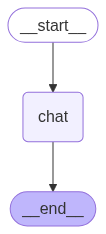

In [37]:
graph = StateGraph(State)

graph.add_node(chat)

graph.add_edge(START, 'chat')

gr = graph.compile(checkpointer=mem)

display(Image(gr.get_graph().draw_mermaid_png()))

In [39]:
config = {'configurable' : {'thread_id' : 'ayad-01012'}}
for chunk in gr.stream({'messages': "hi, mynmae is ayad and i'm from egypt"}, config=config, stream_mode='updates'):
    print(chunk)

{'chat': {'messages': [AIMessage(content="Marhaba Ayad! It's nice to meet you. Welcome to our conversation! Egypt is a beautiful country with a rich history and culture. What brings you here today? Do you have a specific topic you'd like to talk about or ask about? I'm here to listen and help if I can.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 24, 'total_tokens': 88, 'completion_time': 0.053255525, 'prompt_time': 0.003315835, 'queue_time': 0.168679453, 'total_time': 0.05657136}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--938322d2-7f89-4bb5-b8e6-7b1ffdd846c3-0', usage_metadata={'input_tokens': 24, 'output_tokens': 64, 'total_tokens': 88})]}}


In [ ]:
config = {'configurable' : {'thread_id' : 'ayad-0101248'}}
for chunk in gr.stream({'messages': "hi, my name is ayad and i'm from egypt"}, config=config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content="hi, mynmae is ayad and i'm from egypt", additional_kwargs={}, response_metadata={}, id='a8284bcc-7767-4344-8895-bff1af2e0fef')]}
{'messages': [HumanMessage(content="hi, mynmae is ayad and i'm from egypt", additional_kwargs={}, response_metadata={}, id='a8284bcc-7767-4344-8895-bff1af2e0fef'), AIMessage(content="Hello Ayad! It's nice to meet you! I'm excited to learn more about you and your culture. Egypt has a rich and fascinating history, and I'm sure you must have some amazing stories and experiences to share.\n\nWhat brings you here today? Are you interested in learning more about a specific topic, or do you just want to chat and get to know me better?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 24, 'total_tokens': 102, 'completion_time': 0.072747341, 'prompt_time': 0.005402759, 'queue_time': 0.16920828899999998, 'total_time': 0.0781501}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 

In [42]:
config = {'configurable' : {'thread_id' : 'ayad-01012489'}}
async for chunk in gr.astream_events({'messages': "hi, my name is ayad and i'm from egypt"}, config=config, stream_mode='values'):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': "hi, my name is ayad and i'm from egypt"}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'd8475012-22fe-4b06-8535-220b6e476378', 'metadata': {'thread_id': 'ayad-01012489'}, 'parent_ids': []}
{'event': 'on_chain_stream', 'run_id': 'd8475012-22fe-4b06-8535-220b6e476378', 'name': 'LangGraph', 'tags': [], 'metadata': {'thread_id': 'ayad-01012489'}, 'data': {'chunk': {'messages': [HumanMessage(content="hi, my name is ayad and i'm from egypt", additional_kwargs={}, response_metadata={}, id='81f60c94-c3e5-433d-969a-a266fcf5339d'), AIMessage(content="Hello Ayad! Nice to meet you! Egypt is a fascinating country with a rich history and culture. What brings you here today? Are you interested in learning something new, or do you have a specific question or topic you'd like to discuss? I'm here to help and happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 23, 'total_to

# Human In The Loop

In [46]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

In [49]:
@tool
def human_ass(query: str) -> str:
    """Request assistance from a human."""
    return interrupt({'query': query})['data']

In [50]:
tools = [tavily, human_ass]

llm_with_tools = llm.bind_tools(tools)

In [51]:
def chat(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

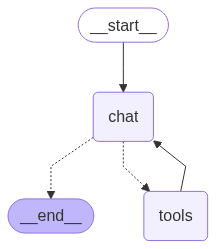

In [58]:
graph = StateGraph(State)

graph.add_node(chat)
graph.add_node(ToolNode(tools))

graph.add_edge(START, 'chat')
graph.add_conditional_edges('chat', tools_condition)
graph.add_edge('tools', 'chat')

gr = graph.compile(checkpointer = mem)

display(Image(gr.get_graph().draw_mermaid_png()))

In [65]:
config = {'configurable' : {'thread_id' : '100'}}

events = gr.stream(
    input = {'messages' : 'I want to request an assistant to ask how can i build ai agent'},
    config = config,
    stream_mode = 'values'
)

for ev in events:
    if 'messages' in ev: ev['messages'][-1].pretty_print()

================================ Human Message =================================

I want to request an assistant to ask how can i build ai agent
================================== Ai Message ==================================
Tool Calls:
  human_ass (3zfr0mefb)
 Call ID: 3zfr0mefb
  Args:
    query: How can I build an AI agent?


In [66]:
ev

{'messages': [HumanMessage(content='I want to request an assistant to ask how can i build ai agent', additional_kwargs={}, response_metadata={}, id='d29abc67-0d35-4aa0-b0bb-adc69f60d55c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3zfr0mefb', 'function': {'arguments': '{"query":"How can I build an AI agent?"}', 'name': 'human_ass'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 2237, 'total_tokens': 2309, 'completion_time': 0.051549265, 'prompt_time': 0.260755967, 'queue_time': 0.181355869, 'total_time': 0.312305232}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eaec296b-332a-4d0c-bb2b-2ed9e2a2ae6f-0', tool_calls=[{'name': 'human_ass', 'args': {'query': 'How can I build an AI agent?'}, 'id': '3zfr0mefb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2237, 'output_tokens': 72, 'total_tokens': 2309})]}

In [67]:
human_resp = ("You can build agentic workflow easily with the help of langgraph framwork")

humen_feedback = Command(resume = {'data' : human_resp})

events = gr.stream(
    humen_feedback,
    config = config,
    stream_mode = 'values'
)

for ev in events:
    if 'messages' in ev: ev['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_ass (3zfr0mefb)
 Call ID: 3zfr0mefb
  Args:
    query: How can I build an AI agent?
================================= Tool Message =================================
Name: human_ass

You can build agentic workflow easily with the help of langgraph framwork
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5x6q1182y)
 Call ID: 5x6q1182y
  Args:
    exclude_domains: []
    include_domains: []
    include_favicon: True
    include_images: False
    query: What is LangGraph framework?
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "What is LangGraph framework?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is 